In [1]:
import json
import geopandas as gpd

#INPUT VARIABLES
config_path = '00_input/korindo.json'
is_export_image_to_drive = False

# to-do, filter the AOI based on size, if the AOI is too big, we will use the GEE approach, if small, we will use the STAC approach
with open(config_path, 'r') as f:
    config = json.load(f)

aoi_gpd = gpd.GeoDataFrame.from_file(config["AOI_path"])
aoi_gpd = aoi_gpd.to_crs(epsg=int(config["output_crs"].split(":")[-1])) # satellite crs is epsg code of projected UTM crs
aoi_ha = aoi_gpd.geometry.area.sum()/10000

if aoi_ha > 5000: # 5,000 is the threshold for the AOI size
    print(f"AOI area ({aoi_ha} ha) is too big, using GEE approach when available and mix with STAC MPC")
    use_gee = True
else:
    print(f"AOI area ({aoi_ha} ha) is small, using STAC (local process xarray) approach")
    use_gee = False

AOI area (144217.6737820076 ha) is too big, using GEE approach when available and mix with STAC MPC


In [2]:
!pip install gcsfs

In [3]:
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
from forestry_carbon_arr.utils.zarr_utils import load_dataset_zarr
import os

zarr_path = os.getenv('GCS_ZARR_DIR') + '/ds_resampled.zarr'
# zarr_path = 'data/ds_resampled.zarr'
# storage = 'local'
storage = 'gcs'

ds_resampled = load_dataset_zarr(zarr_path, storage=storage)
ds_resampled

📂 Loading dataset from GCS zarr: gs://remote_sensing_saas/01-korindo/timeseries_zarr/ds_resampled.zarr
✅ Dataset loaded: {'time': 81, 'x': 4489, 'y': 3213}


/usr/src/app/forestry_carbon_arr/utils/zarr_utils.py:297: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"✅ Dataset loaded: {dict(ds.dims)}")


<xarray.Dataset> Size: 9GB
Dimensions:   (time: 81, x: 4489, y: 3213)
Coordinates:
    image_id  (time) <U17 6kB dask.array<chunksize=(40,), meta=np.ndarray>
  * time      (time) datetime64[ns] 648B 2018-02-15 2018-05-15 ... 2025-08-15
  * x         (x) float64 36kB 5.786e+05 5.786e+05 ... 6.235e+05 6.235e+05
  * y         (y) float64 26kB 9.949e+06 9.949e+06 ... 9.982e+06 9.982e+06
Data variables:
    EVI       (time, x, y) float32 5GB dask.array<chunksize=(40, 1024, 1024), meta=np.ndarray>
    NDVI      (time, x, y) float32 5GB dask.array<chunksize=(40, 1024, 1024), meta=np.ndarray>
Attributes:
    crs:      EPSG:32749

In [5]:
import ee, eemont
import pandas as pd
import numpy as np
from forestry_carbon_arr.core import ForestryCarbonARR

forestry = ForestryCarbonARR(config_path='./00_input/korindo.json')

# Use the renamed method
results = forestry.get_ds_sampled_mpc(
    zarr_path=zarr_path,
    create_visualization=True,
    # save_map=True,  # Opt-in to save HTML
    save_map=False,
    map_filename='my_map.html'  # Optional custom filename # ignore when save_map is False
)

# Or save manually later
# results['visualization'].save('map.html')

/opt/venv/lib/python3.12/site-packages/geemap/conversion.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


📂 Loading dataset from GCS zarr: gs://remote_sensing_saas/01-korindo/timeseries_zarr/ds_resampled.zarr


/usr/src/app/forestry_carbon_arr/utils/zarr_utils.py:297: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"✅ Dataset loaded: {dict(ds.dims)}")


✅ Dataset loaded: {'time': 81, 'x': 4489, 'y': 3213}
✓ GEE Initialized successfully
  Credentials Path: /usr/src/app/user_id.json - loaded successfully
Creating visualization map...
🗺️ CREATING UNIFIED STAC VISUALIZATION
Adding STAC scene versions: S2A_MSIL2A_20171026T023801_R089_T49MEV
Found 2 versions to overlay
   1. S2A_MSIL2A_20171026T023801_R089_T49MEV_20201015T021831 - green boundary
   2. S2A_MSIL2A_20171026T023801_R089_T49MEV_20201015T021828 - orange boundary
✅ Added 2 STAC scene version layers
Returning folium map object: <class 'folium.folium.Map'>
✅ Visualization created
Visualization type: <class 'folium.folium.Map'>
🔗 MICROSOFT PLANETARY COMPUTER URLs
📍 Your area center: -0.3125, 111.9082
📍 Bbox: (111.706493374869, -0.457839253478653, 112.109836017418, -0.167195667545911)

🛰️ Sentinel-2 L2A (Natural Color):
  https://planetarycomputer.microsoft.com/explore?c=111.9081646961435%2C-0.312517460512282&z=12&v=2&d=sentinel-2-l2a&s=false%3A%3A100%3A%3Atrue&ae=0&sr=desc&m=Most+rec

In [6]:
# Display the geemap directly
results['visualization']

In [8]:
# results['ds_resampled']

In [10]:
# results['mpc_date_range']

In [11]:
results['mpc_urls']

{'🛰️ Sentinel-2 L2A (Natural Color)': 'https://planetarycomputer.microsoft.com/explore?c=111.9081646961435%2C-0.312517460512282&z=12&v=2&d=sentinel-2-l2a&s=false%3A%3A100%3A%3Atrue&ae=0&sr=desc&m=Most+recent+%28low+cloud%29&r=Natural+color',
 '🛰️ Sentinel-2 L2A (False Color)': 'https://planetarycomputer.microsoft.com/explore?c=111.9081646961435%2C-0.312517460512282&z=12&v=2&d=sentinel-2-l2a&s=false%3A%3A100%3A%3Atrue&ae=0&sr=desc&m=Most+recent+%28low+cloud%29&r=Short+wave+infrared',
 '🛰️ Landsat 8-9 (Natural Color)': 'https://planetarycomputer.microsoft.com/explore?c=111.9081646961435%2C-0.312517460512282&z=12&v=2&d=landsat-c2-l2&s=false%3A%3A100%3A%3Atrue&ae=0&sr=desc&m=Most+recent+%28low+cloud%29&r=Natural+color'}

In [12]:
# ds_resampled

In [13]:
# os.getenv('GCS_ZARR_DIR')

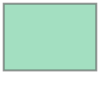

In [ ]:
### Download Sentinel-2 satellite data from Microsoft Planetary Computer (MPC)
### This uses the bbox and date_range_mpc from the previous get_ds_sampled_mpc results

# Get bbox and date_range_mpc from results
bbox = results['bbox']
date_range_mpc = results['mpc_date_range']
date_range_str = results['mpc_date_range'][0]+'_'+results['mpc_date_range'][1]
satellite_type = forestry.config['collection_mpc']
project_name = forestry.config['project_name']

zarr_path = os.path.join(os.getenv('GCS_ZARR_DIR'), f'{satellite_type}_{project_name}_{date_range_str}.zarr')

print("📡 Using STAC (Microsoft Planetary Computer) approach...")
print(f"📅 Date range: {date_range_mpc}")

# Customize chunk sizes for zarr storage
# Default is {'time': 10, 'x': 512, 'y': 512}
# Adjust based on your data size and memory constraints
chunk_sizes = {
    'time': 10,   # Number of time steps per chunk
    'x': 512,     # Number of pixels in x direction per chunk
    'y': 512      # Number of pixels in y direction per chunk
}

# Download and process satellite data
ds_sentinel_mpc = forestry.get_satellite_mpc(
    bbox=bbox,  # Can be None - will use from previous results
    date_range_mpc=date_range_mpc,  # Can be None - will use from previous results
    utm_crs='EPSG:32749',  # can be auto from bbox too
    pixel_scale=None,  # Auto-detect (10m for Sentinel-2)
    zarr_path=zarr_path,  # Custom path with date range and satellite type
    chunk_sizes=chunk_sizes,  # Custom chunk sizes for zarr storage
    save_to_zarr=True,  # Save to zarr
    storage='auto',  # Auto-detect (GCS if GCS_ZARR_DIR env var is set)
    show_progress=True
)

print(f"\n✅ Dataset downloaded: {dict(ds_sentinel_mpc.sizes)}")
print(f"📊 Data variables: {list(ds_sentinel_mpc.data_vars)}")

### for local zarr saving
# ds_sentinel_mpc = forestry.get_satellite_mpc(
#     bbox=bbox,
#     date_range_mpc=date_range_mpc,
#     zarr_path='data/my_custom_folder/sentinel2.zarr',  # Custom local path
#     storage='local'
# )